In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import glob
import os

os.chdir('/Users/vivekkanpa/Documents/UCD/sudoku-imputation/SUDOKU_BENCHMARK/analysis')
os.getcwd()

missingness = 'mar'
dataset = 'arcene'

In [2]:
os.getcwd()

'/Users/vivekkanpa/Documents/UCD/sudoku-imputation/SUDOKU_BENCHMARK/analysis'

In [3]:
results_mean = pd.read_csv(f"results_tables/benchmarking_results/{dataset}/{missingness}/benchmarking_mean_metrics.csv", index_col=0)
results_se = pd.read_csv(f"results_tables/benchmarking_results/{dataset}/{missingness}/benchmarking_se_metrics.csv", index_col=0)

In [4]:
results_mean.head()

,R2,Pearson_r,RMSE,MAE,n_imputed,n_scored,missingness_prop
sudoku,0.285265,0.568740,0.230344,0.149861,299.838384,299.838384,0.4
median,-0.552761,NaN,0.314308,0.174287,299.838384,299.838384,0.4
mean,-0.437624,NaN,0.292941,0.210880,299.838384,299.838384,0.4
knn,0.169479,0.502287,0.240781,0.146190,299.838384,299.838384,0.4
factorization,0.168851,0.520711,0.241707,0.129753,299.838384,299.838384,0.4


In [5]:
directory_path = f"results_figures/{dataset}/{missingness}"

try:
    os.makedirs(directory_path, exist_ok=True)
except OSError as e:
    print(f"Error creating directory '{directory_path}': {e}")


In [6]:
results_mean.sort_values(by='missingness_prop').to_csv(f'results_tables/all_results/mega_tables/{missingness}_{dataset}_mega_results.csv')

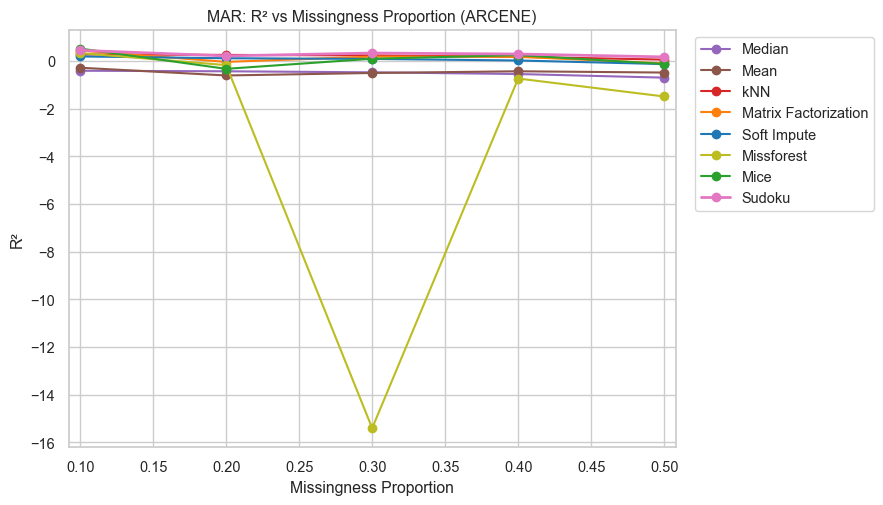

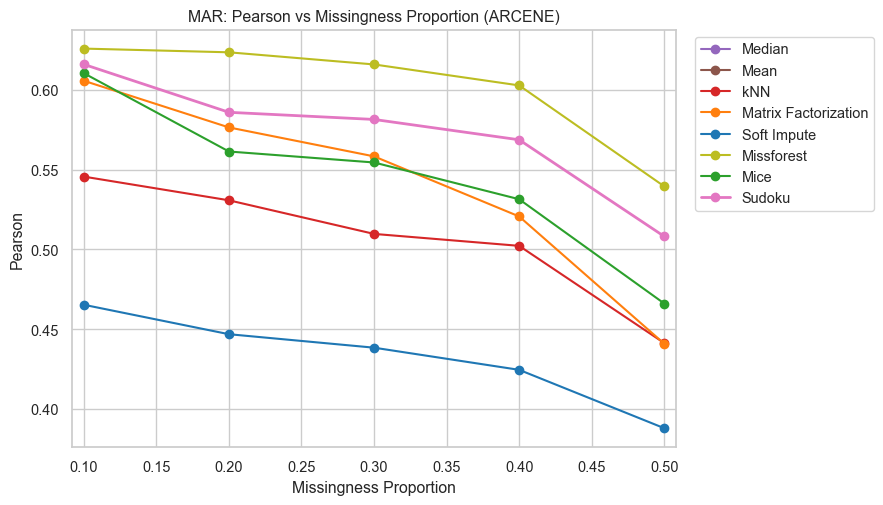

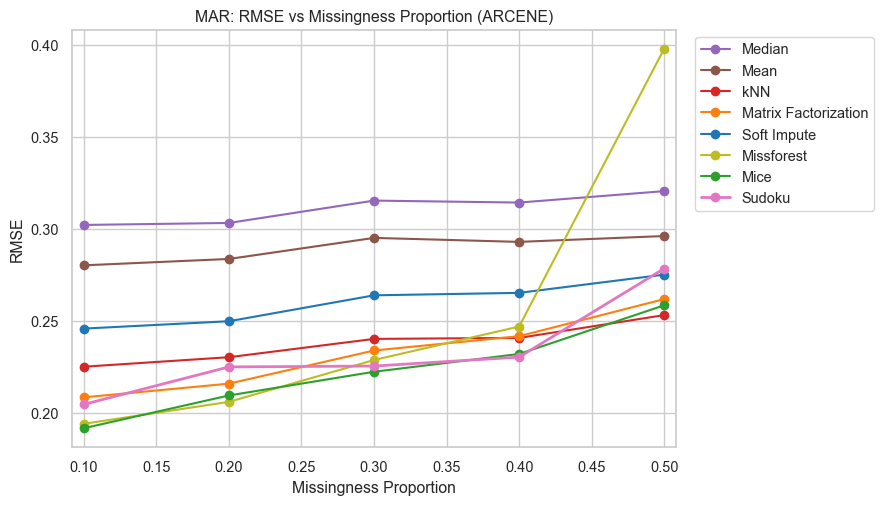

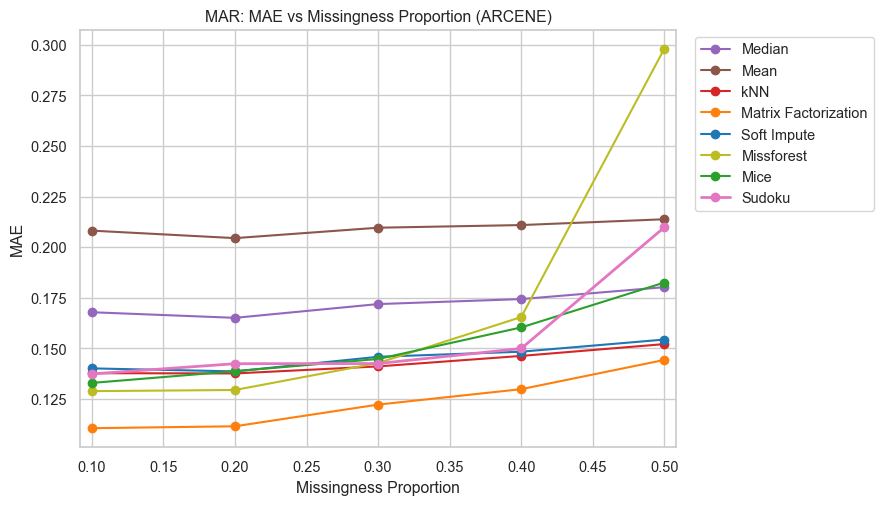

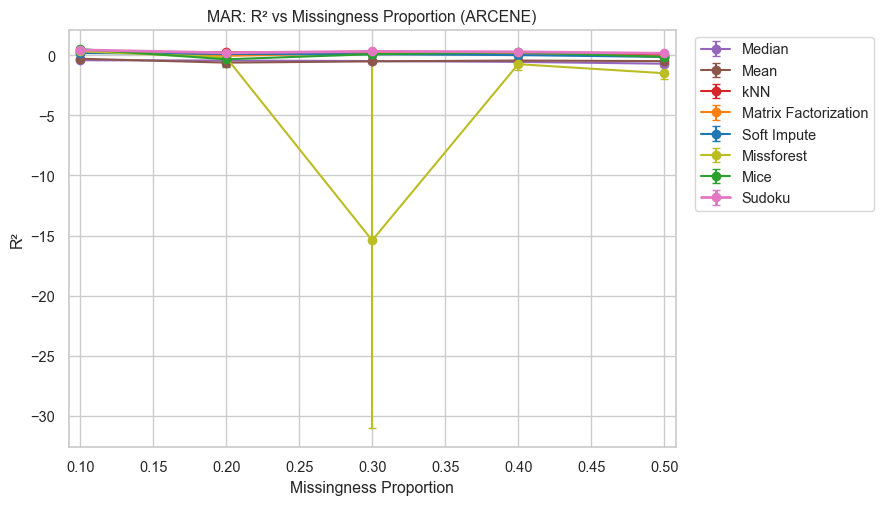

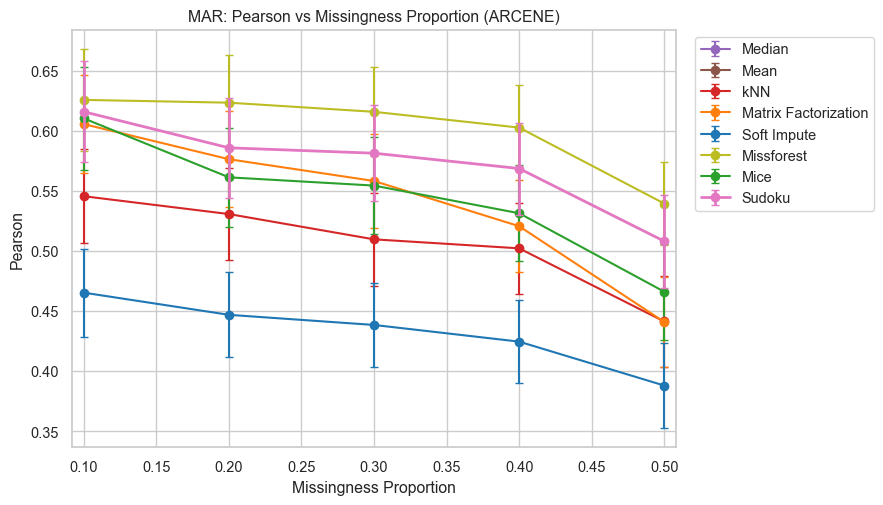

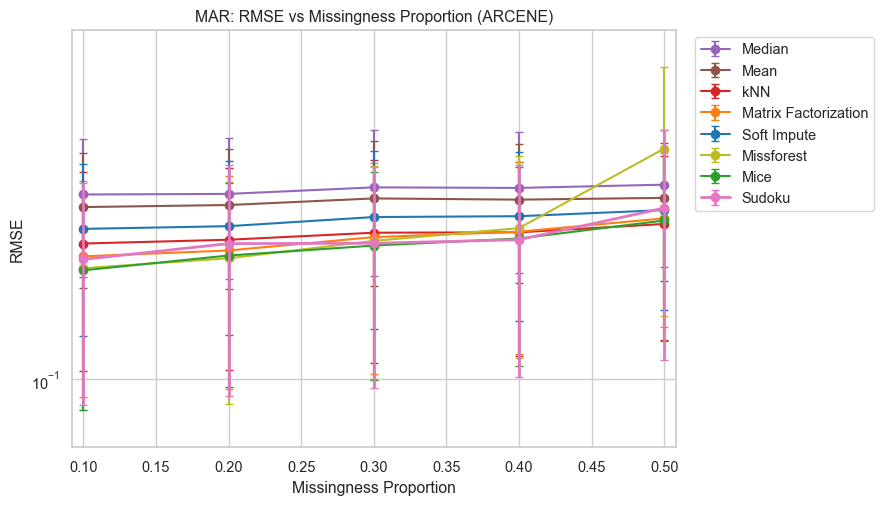

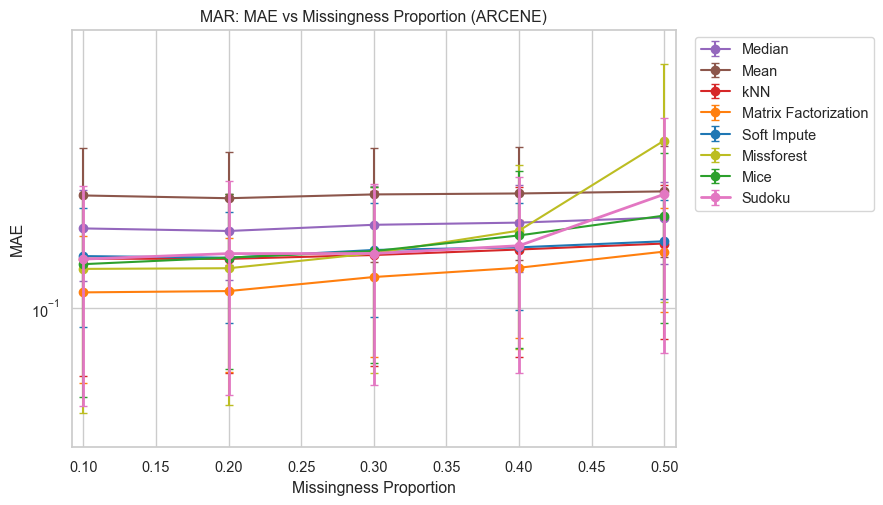

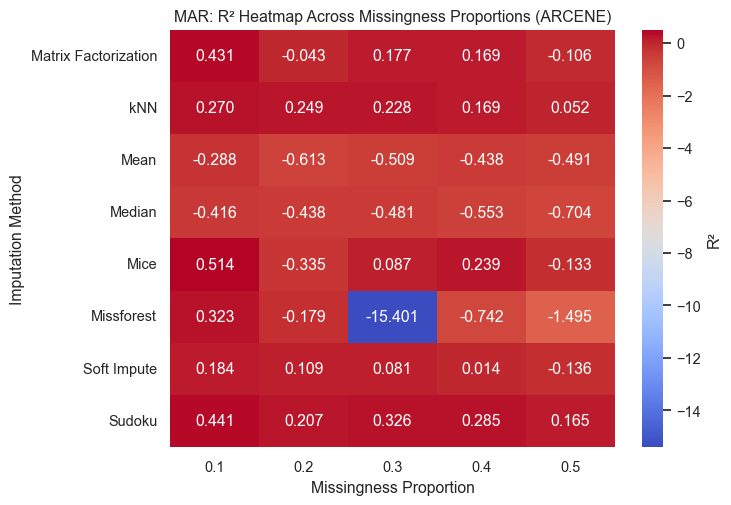

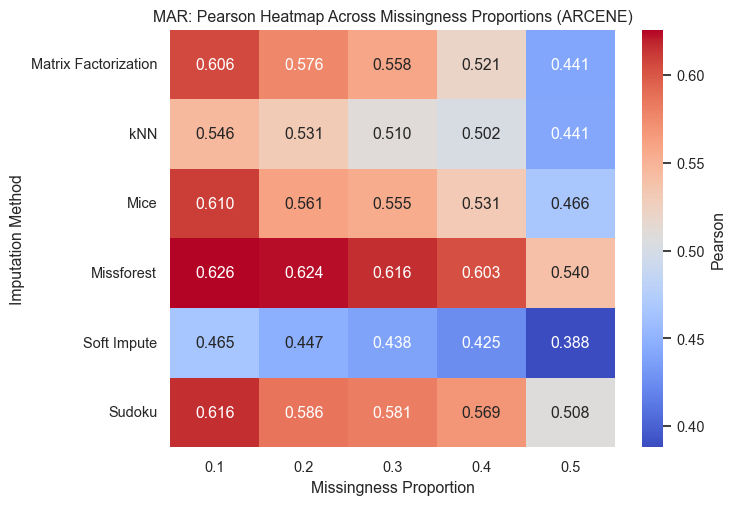

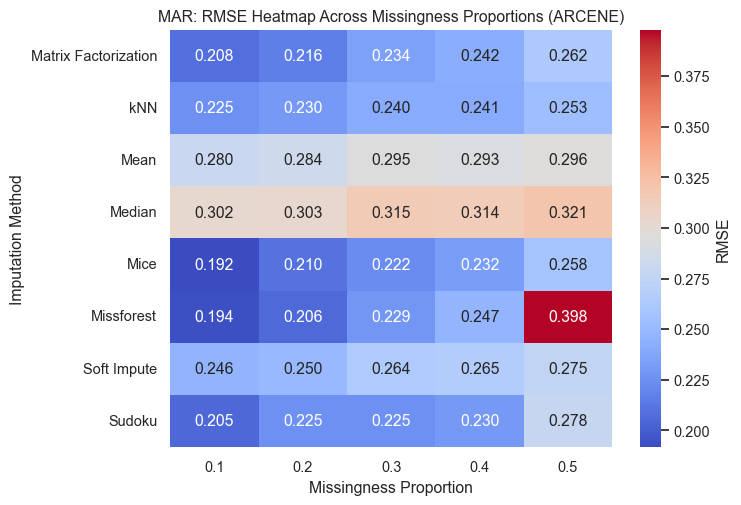

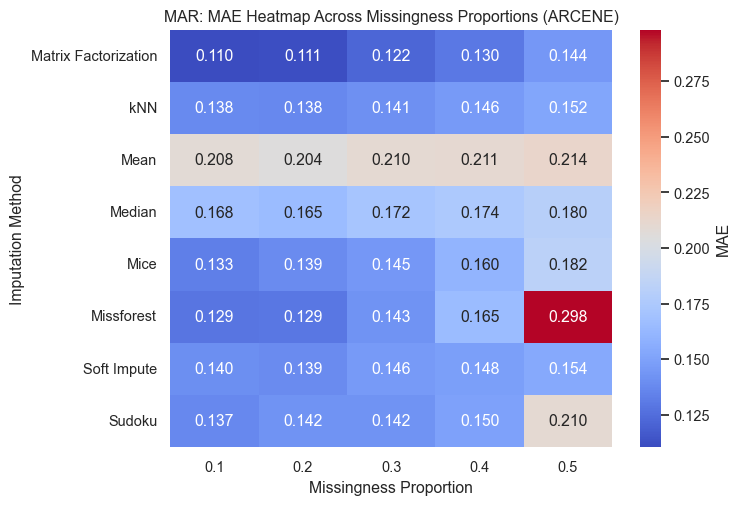

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="notebook", font_scale=0.95)

metrics = ["R2", "Pearson_r", "RMSE", "MAE"]

# Fixed color mapping for consistency across plots
method_colors = {
    "sudoku": "tab:pink",
    "factorization": "tab:orange",
    "mice": "tab:green",
    "knn": "tab:red",
    "median": "tab:purple",
    "mean": "tab:brown",
    "softimpute": "tab:blue",
    "missforest": "tab:olive"
}

# Mapping from internal metric keys → display names
metric_display_names = {
    "Pearson_r": "Pearson",
    "R2": "R\u00b2"
}

def get_metric_display_name(metric):
    return metric_display_names.get(metric, metric)  # default: unchanged

# Mapping from internal keys → pretty display names
method_display_names = {
    "factorization": "Matrix Factorization",
    "softimpute": "Soft Impute",
    "knn": "kNN" 
}


def get_display_name(m):
    """Return the display name for a method."""
    if m in method_display_names:
        return method_display_names[m]
    return m.capitalize()  # fallback: capitalize first letter

# ---------- Line Plots without Error Bars ----------
for metric in metrics:
    plt.figure(figsize=(9, 5.2))

    # Reorder so sudoku plots on top
    methods = list(results_mean.index.unique())
    methods = [m for m in methods if m != "sudoku"] + ["sudoku"]

    # ---- pass 1: compute global y-limits including error bars ----
    ys_all = []
    for m in methods:
        dfm = results_mean.loc[m].sort_values("missingness_prop")
        ys_all.append(dfm[metric].to_numpy())
    ys_all = np.concatenate(ys_all)
    
    # Compute global min/max and pad a bit
    base_min = np.nanmin(ys_all)
    base_max = np.nanmax(ys_all)
    
    pad = 0.05 * (base_max - base_min if np.isfinite(base_max - base_min) else 1.0)
    ylo, yhi = base_min - pad, base_max + pad


    # ---- pass 2: plot with consistent limits ----
    for m in methods:
        dfm = results_mean.loc[m].sort_values("missingness_prop")
        dfs = results_se.loc[m].sort_values("missingness_prop")

        x = dfm["missingness_prop"].to_numpy()
        y = dfm[metric].to_numpy()
        yerr = np.maximum(dfs[metric].to_numpy(), 0.0)

        plt.errorbar(
            x, y, #yerr=yerr,
            label=get_display_name(m),   # <-- FIXED DISPLAY NAME HERE
            color=method_colors.get(m, None),
            marker="o", capsize=3,
            zorder=3 if m == "sudoku" else 2,
            linewidth=2.0 if m == "sudoku" else 1.5,
        )

    plt.xlabel("Missingness Proportion")

    plt.ylabel(get_metric_display_name(metric))
    plt.title(f"{missingness.upper()}: {get_metric_display_name(metric)} vs Missingness Proportion ({dataset.upper()})")

    plt.ylim(ylo, yhi)

    plt.margins(x=0.02)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
    plt.tight_layout()

    plt.savefig(f'{directory_path}/{dataset}_{missingness}_{metric}_lineplot.svg',
                bbox_inches="tight")
    plt.savefig(f'{directory_path}/{dataset}_{missingness}_{metric}_lineplot.png',
                bbox_inches="tight")
    plt.show()
    
# ---------- Line Plots WITH Error Bars ----------
for metric in metrics:
    plt.figure(figsize=(9, 5.2))

    # Reorder so sudoku plots on top
    methods = list(results_mean.index.unique())
    methods = [m for m in methods if m != "sudoku"] + ["sudoku"]

    # ---- pass 1: compute global y-limits including error bars ----
    ys_all, yerrs_all = [], []
    for m in methods:
        dfm = results_mean.loc[m].sort_values("missingness_prop")
        dfs = results_se.loc[m].sort_values("missingness_prop")
        ys_all.append(dfm[metric].to_numpy())
        yerrs_all.append(np.maximum(dfs[metric].to_numpy(), 0.0))
    ys_all = np.concatenate(ys_all)
    yerrs_all = np.concatenate(yerrs_all)

    if metric in ("RMSE", "MAE"):
        eps = 1e-12
        base_min = np.min(np.maximum(ys_all - yerrs_all, eps))
        base_max = np.max(np.maximum(ys_all + yerrs_all, eps))
        ylo, yhi = base_min / 1.25, base_max * 1.25
        use_log = True
    else:
        base_min = np.nanmin(ys_all - yerrs_all)
        base_max = np.nanmax(ys_all + yerrs_all)
        pad = 0.05 * (base_max - base_min if np.isfinite(base_max - base_min) else 1.0)
        ylo, yhi = base_min - pad, base_max + pad
        use_log = False

    # ---- pass 2: plot with consistent limits ----
    for m in methods:
        dfm = results_mean.loc[m].sort_values("missingness_prop")
        dfs = results_se.loc[m].sort_values("missingness_prop")

        x = dfm["missingness_prop"].to_numpy()
        y = dfm[metric].to_numpy()
        yerr = np.maximum(dfs[metric].to_numpy(), 0.0)

        if use_log:
            y = np.maximum(y, 1e-12)

        plt.errorbar(
            x, y, yerr=yerr,
            label=get_display_name(m),   # <-- FIXED DISPLAY NAME HERE
            color=method_colors.get(m, None),
            marker="o", capsize=3,
            zorder=3 if m == "sudoku" else 2,
            linewidth=2.0 if m == "sudoku" else 1.5,
        )

    plt.xlabel("Missingness Proportion")

    plt.ylabel(get_metric_display_name(metric))
    plt.title(f"{missingness.upper()}: {get_metric_display_name(metric)} vs Missingness Proportion ({dataset.upper()})")

    if use_log:
        plt.yscale("log")
        plt.ylim(ylo, yhi)
    else:
        plt.ylim(ylo, yhi)

    plt.margins(x=0.02)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
    plt.tight_layout()

    plt.savefig(f'{directory_path}/SUPP_{dataset}_{missingness}_{metric}_lineplot_supp.svg',
                bbox_inches="tight")
    plt.savefig(f'{directory_path}/SUPP_{dataset}_{missingness}_{metric}_lineplot_supp.png',
                bbox_inches="tight")
    plt.show()

# ---------- Heatmaps ----------
for metric in metrics:
    pivot = results_mean.pivot_table(
        index=results_mean.index,
        columns="missingness_prop",
        values=metric
    )
    # Update row labels to use display names
    pivot = pivot.rename(index=get_display_name)

    plt.figure(figsize=(7.5, 5.2))
    ax = sns.heatmap(
        pivot, annot=True, fmt=".3f",
        cmap="coolwarm", cbar_kws={'label': get_metric_display_name(metric)}
    )
    plt.title(f"{missingness.upper()}: {get_metric_display_name(metric)} Heatmap Across Missingness Proportions ({dataset.upper()})")
    plt.ylabel("Imputation Method")
    plt.xlabel("Missingness Proportion")
    plt.tight_layout()
    plt.savefig(f'{directory_path}/{dataset}_{missingness}_{metric}_heatmap.svg',
                bbox_inches="tight")
    plt.savefig(f'{directory_path}/{dataset}_{missingness}_{metric}_heatmap.png',
                bbox_inches="tight")
    plt.show()
